In [1]:
import numpy as np
import warnings
from sklearn import decomposition
import matplotlib.pyplot as plt

#suppress warnings
warnings.filterwarnings('ignore')

# BLG527E - Machine Learning, Homework 3

In this homework, you are supposed to implement following parts:
     
- **Part 1: solve an SVM optimization problem by hand (50 points)**

- **Part 2: Federate a logistic regression classifier (40 points)**

- **Part 3: practice feature selection (10 points)**
     - Refer to Machine Learning Blinks 10 and 11 for this part:
     - ML Blinks 10: https://www.youtube.com/watch?v=laeth5oT9YM&list=PLug43ldmRSo1LDlvQOPzgoJ6wKnfmzimQ
     - ML Blinks 11: https://www.youtube.com/watch?v=mRmVKNklE9I&list=PLug43ldmRSo1LDlvQOPzgoJ6wKnfmzimQ 
 
 
 
 ### Important Notes:
   - Please complete this template and include any other necessary materials (screenshots of your handwritten solutions etc.) into the HW3 folder. Then zip it again and submit to Ninova.
   - At Part 1, you can upload the screenshots of your handwritten solutions to the Notebook. But please be sure that your solutions are neat and can be read properly.
   - For the Part 2, you will Federate a classifier across 20 datasets. Check the paper in Part 2.2 for more details. 
   - For the Part 3, you should implement feature selection from scratch however can use scikit-learn built-in functions for training the SVM.
   - You can ask your questions via kamard@itu.edu.tr 
    



## Part 1: Solving SVM optimization by hand (50 points)

You can insert the screenshots of your handwritten solution on Jupyter Notebook. For an example, check the cells including images. Do not forget to include your solution image file into the submitted .zip file.

Some reminders for the question:

 - Lagrangian to optimize: $\mathcal{L}_{primal} = \sum_{i=1}^{n} a_{i} - \frac{1}{2} [\sum_{i=1}^{n}\sum_{j=1}^{n}\alpha_{i}\alpha_{j}y_{i}y_{j}x_{i}^{T}x^{j}] $ 


- Constraint: $\sum_{i=1}^{n} \alpha_{i} y_{i} = 0$


- Optimal parameter: $w^{*} = \sum_{i=1}^{n} \alpha_{i} y_{i} x^{i}$

### Part 1.1 (25 points)

<p style="float: left;"><img src="images/Part1-1.png" width = "200"></p>
        
        Given the two following training samples (n=2), provide below a step-by-step solution
        to estimate the optimal parameters (w and b) of the hyperplane separating the two classes.

### Part 1.1 Solution

<p style="float: left;"><img src="images/Part1.1.1.jpeg" width = "200"></p>
<p style="float: left;"><img src="images/Part1.1.2.jpeg" width = "200"></p>
<p style="float: left;"><img src="images/Part1.1.3.jpeg" width = "200"></p>
<p style="float: left;"><img src="images/Part1.1.4.jpeg" width = "200"></p>

### Part 1.2 (15 points) 
If we add a third training point $x_3 = \left [\begin{matrix} -4 \\ 4 \end{matrix}\right] $, will that impact the hyperplane estimated using points $x_1$ and $x_2$? Answer this considering two cases where label for $x_3$ is (1) $y_3 = +1 $, (2) $y_3 = -1 $ and justify. You do not need to solve Lagrangian again, justify your answer drawing the hyperplanes and giving explanations.

### Part 1.2 Solution

<p style="float: left;"><img src="images/Part1.2.1.jpeg" width = "200"></p>
<p style="float: left;"><img src="images/Part1.2.2.jpeg" width = "200"></p>

### Part 1.3 (10 points)
Explain how to classify the point $x_{test} = \left [\begin{matrix} -4 \\ -3 \end{matrix}\right] $ using the estimated model at Part 1.1. What is the predicted label of $x_{test}$? 

### Part 1.3 Solution

<p style="float: left;"><img src="images/Part1.3.1.jpeg" width = "200"></p>

## Part 2: Federate a logistic regression classifier across 20 datasets (40 points)

We set out to classify two digits from the MNIST dataset: digit 0 to which we assign the label 0 and digit 1 to which we assign the label 1 using the code of the logistic regression based on the softmax loss. You are allowed to use built-in functions from scikit-learn in the specified parts below, which you can install via one of the following commands (depending on which one you use):

        > python3 -m pip install scikit-learn
        > conda install -c conda-forge scikit-learn

We have 20 local datasets distributed across 20 clients and 1 global test dataset left for testing. The function **parse_mnist_into_clients** in the following cell creates the datasets from the shared files. You do NOT need to change the function. You can simply run the following cell and it will load the datasets for you!

In [2]:
def parse_mnist_into_clients():
    '''
    Parses the MNIST data files into 20 local datasets for clients and 1 global test dataset. 
    Do NOT change this function!
    
    
    Outputs:
    
    local_datasets_data: The MNIST data of the local 20 dataset
    local_datasets_label: Labels of the 20 local dataset. local_datasets_data[i] corresponds to local_datasets_label[i]
    test_data : Global Test Data
    test_label: Labels of the global test data
    '''
    data = np.load('mnist_data.npy')
    labels = np.load('mnist_labels.npy')
    local_datasets_data  = []
    local_datasets_label = []
    
    for i in range(20):
        local_datasets_data.append(np.copy(data[i*703:(i+1)*703]))
        local_datasets_label.append(np.copy(labels[i*703:(i+1)*703]))
    
    test_data = np.copy(data[14060:])  
    test_labels = np.copy(labels[14060:])
    
    return local_datasets_data, local_datasets_label, test_data, test_labels

# Load the data
client_data, client_label, test_data, test_label = parse_mnist_into_clients()

A simple example code of the logistic classifier using softmax loss is included below. Use this code to federate the learning of the 20 clients and test their local models on the left-out test dataset. Note that the code below is a very simple logistic regression code and the hyper parameters is not optimized. Feel free to modify it depending on what you need.

In [3]:
def sigmoid(x):
    return 1/ (1 + np.exp(-x))

def calculate_grad(X, y, w): # gradient of the loss function least square cost by using sigmoid(xw + b)
    s = sigmoid(-y * (X @ w))
    grad = -X.T @ (s * y)
    grad = np.mean(grad, axis=1, keepdims=True) # mean error across samples
    return grad

def client_update(k, w, E): # this is designed for B equals infinity (select all training data of that client)
    alpha = 10**-2 # learning rate
    X = client_data_reduced[k] # kth client can only see the kth data 
    y = client_label[k] # kth client can only see the kth labels
    
    for epoch in range(E):
        grad = calculate_grad(X,y,w) # gradient of the loss function wrt to w
        w = w - alpha * grad # update rule of gradient descent
        
    return w

### Part 2.1 (10 points)

Use built-in PCA from scikit-learn library to reduce the dimensionality of the training and testing samples to only two dimension (PC1 and PC2). PS: Watch <a href='https://www.youtube.com/watch?v=mRmVKNklE9I&list=PLug43ldmRSo1LDlvQOPzgoJ6wKnfmzimQ&index=45'>lecture 11</a> (beware of the eavesdropping phenomenon!). Note also that PCA should be applied to each client independently. In federated learning, clients never share data.


In [4]:
def apply_pca(data):
    pca = decomposition.PCA(n_components=2)
    pca.fit(data)
    reduced_data = pca.transform(data)
    return reduced_data

# for training
# client_data_reduced data structure is used to hold all clients but in client update each client is only allowed to reach kth elements
client_data_reduced = []
for X in client_data: # do this for each different client
    X_reduced = apply_pca(X)
    client_data_reduced.append(X_reduced)
    
# for testing #TODO: should the testing data be independent of training
test_data_reduced = apply_pca(test_data)

### Part 2.2 (20 points)

From now on we will use the reduced 2-dimensional training and test datasets. Train a logistic classifier on the reduced 2-dimensional dataset for each client, independently, send the model weights to the server, aggregate and broadcast back to all clients.

Basically, implement the **FederatedAveraging** algorithm in **(https://arxiv.org/pdf/1602.05629.pdf)** for B = infinity (i.e., each client will be trained on all its local training samples). 


In [5]:
def server(K, E, number_of_pca_dim, max_round, test_every_round):    
    client_weights = np.zeros((K, number_of_pca_dim, 1)) # (20, 2, 1)
    w_0 = np.random.randn(number_of_pca_dim,1)
    
    w_t = w_0
    acc_list = []
    for t in range(max_round): # at each round weights of the server is updated
        for k in range(K): # for each client
            client_weights[k] = client_update(k, w_t, E)
            
        w_t = np.mean(client_weights, axis=0) # update server weights by getting mean weights of all clients, since each client has same number of samples, I didn't use weighted weights (s.t. n_k/n)
        
        if t % test_every_round == 0:
            acc = test_logistic_classifier(w_t, test_data_reduced, test_label) # test with the lastly updated weights
            acc_list.append(acc)
            
    return acc_list
    
def federated_averaging(K, E, number_of_pca_dim, max_round, test_every_round):
    acc_list = server(K, E, number_of_pca_dim, max_round, test_every_round)
    return acc_list

### Part 2.3 (10 points)

Test the global (aggregated model) on the left-out test dataset. Plot the test classification accuracy on the global dataset against the number of communication rounds for E = 1, 5 and 10. You might need to use a small number of communication rounds if the convergence is fast. Note that B is always set to infinity. Check out Figure 2 in the paper for more details. What do you notice? Discuss your results.

In [6]:
def test_logistic_classifier(w, test_data_reduced, test_label):
    preds = sigmoid(np.dot(test_data_reduced, w))

    correct = 0
    n_test_samples = len(test_label)
    for i in range(n_test_samples):
        if test_label[i] == preds[i]:
            correct += 1
                
    acc = correct/n_test_samples
    return acc

Testing at [ 5. 10. 15. 20. 25. 30. 35. 40. 45. 50.] communication rounds.

Testing acc E=1 [0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222]


Testing acc E=5 [0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222]


Testing acc E=10 [0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222]



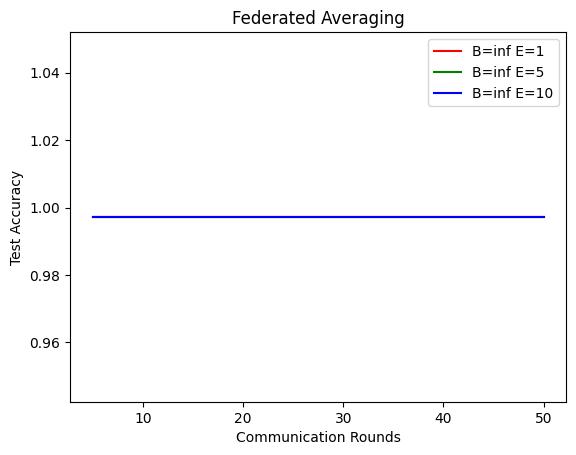

In [7]:
np.random.seed(2) # to make sure initial weights are same for each run, for reproducibility guarantee 

K = 20 # number of clients
number_of_pca_dim = 2 # number of new projected features of the data

max_round = 50 # Communication Rounds a.k.a number of update of weights in the server
test_every_round = 5 # when to test of the weights of the server
x_axis = np.linspace(test_every_round, max_round, int(max_round/test_every_round))
print(f"Testing at {x_axis} communication rounds.")

E_list = [1, 5, 10] # number of local epochs
color_list = ["-r", "-g", "-b"]
for E, c in zip(E_list, color_list):
    acc_list = federated_averaging(K, E, number_of_pca_dim, max_round, test_every_round)
    plt.plot(x_axis, acc_list, c, label=f"B=inf E={E}")
    print(f"\nTesting acc E={E} {acc_list}\n")

plt.xlabel('Communication Rounds')
plt.ylabel('Test Accuracy') 
plt.title('Federated Averaging')
plt.legend()
plt.show()

# TODO: PCA kısmından emin ol
# TODO: buraya discussion yaz

## Part 3: Feature selection using Variance Threshold (10 points)

In this part, we will use scikit-learn library for training SVM. To remind you, you can install the scikit-learn using following commands:

        > python3 -m pip install scikit-learn
        > conda install -c conda-forge scikit-learn
        
There are lots of machine learning techniques that are available in scikit-learn library. In this problem we will use the **SVM** classifier with linear kernel and implement Variance Threshold feature selection method from scratch.
   

You can check the documentations on the internet to learn how to use SVM classifier and which parameters to use. Necessary functions are imported below.

In [8]:
# This file is associated with the book
# "Machine Learning Refined", Cambridge University Press, 2016.
# by Jeremy Watt, Reza Borhani, and Aggelos Katsaggelos.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.svm import SVC
import sklearn.datasets as ds

from sklearn.model_selection import train_test_split

We will implement feature selection on handwritten digits dataset. In the following cell we load and examine dataset. As you can see the samples are 8 by 8 images where in each row of X, the images are kept as flatten vectors. Each feature represents a pixel (i.e 0th feature is (0, 0) pixel and 8th feature is (1, 0) pixel.

Number of samples:  1797
Number of attributes:  64
Classes:  [0 1 2 3 4 5 6 7 8 9]


<Figure size 640x480 with 0 Axes>

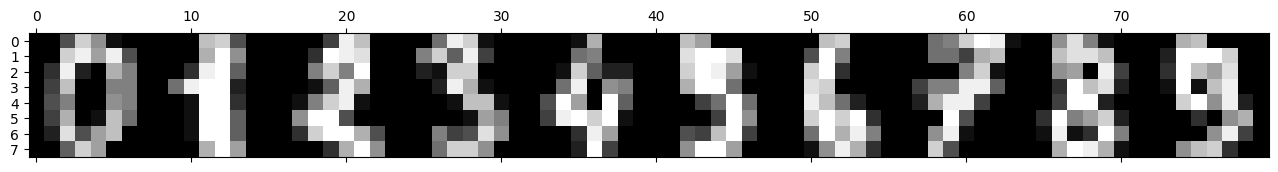

In [9]:
digit_data = ds.load_digits()
print("Number of samples: ", digit_data.data.shape[0])
print("Number of attributes: ", digit_data.data.shape[1])
print("Classes: ", digit_data.target_names)

c = digit_data.images[0]
for i in range(1, 10):
    c = np.concatenate((c, digit_data.images[i]), 1)

plt.gray() 
plt.matshow(c)
plt.show()

Then we split the data into training and testing sets in order to train the models on training set and test them on unseen test set. Do not change the random state so we will get the same train and test splits.

In [10]:
X, y = digit_data.data, digit_data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state=20)

print("Number of training samples: ", X_train.shape[0])
print("Number of testing samples: ", X_test.shape[0])

Number of training samples:  1437
Number of testing samples:  360


 In the following cell, you should complete the necessary train and test functions for SVM. Fill the specified parts only. Calculate the accuracy score as:

<br>
<center> $ Accuracy = \frac{\#correct \ predictions}{\#total \ samples} $ </center>
<br>

In [11]:
def train(X, y):
    classifier = SVC(kernel="linear")  # define the classifier
    classifier.fit(X, y)  # fit the classifier on training set
    
    preds = classifier.predict(X)  # predict the labels for training set
  
    correct = 0
    n = len(y)
    for i in range(n):
        if preds[i] == y[i]:
            correct += 1
    train_accuracy = correct/n  # calculate the accuracy (do not use built-in function)
    
    return classifier, train_accuracy

def test(classifier, X, y):
    preds = classifier.predict(X)  # predict the labels for test set
    
    correct = 0
    n = len(y)
    for i in range(n):
        if preds[i] == y[i]:
            correct += 1    
    test_accuracy = correct/n  # calculate the accuracy on test set
    
    return test_accuracy

 Next, use these function to train and test an SVM without feature selection.

In [12]:
# SVM classifier without feature selection
svm, train_acc = train(X_train, y_train) # call train function with necessary parameters
test_acc = test(svm, X_test, y_test)  # call test function with necessary parameters

print("Train acc without feature selection: ", train_acc)
print("Test acc without feature selection: ", test_acc)

Train acc without feature selection:  1.0
Test acc without feature selection:  0.975


 Now, implement Variance Threshold feature selection method on the dataset. The Variance Threshold basicly follows these steps:
  - Calculate the variances of each feature in the dataset. (Hint: You can use numpy for this)
  - Eliminate the features that has variance less then the given threshold.

In [13]:
def variance_threshold(X, threshold=0):
    selected = [] # keep the indexes of selected feature
    eliminated = [] # keep the indexes of eliminated features
    
    #calculate variances of each feature and eliminate features with variance lower than threshold
    n_features = X.shape[1] # number of features before applying variance threshold
    for f in range(n_features):
        var_f = np.var(X[:,f])
        if var_f < threshold: # eliminate feature
            eliminated.append(f)
        else: # select feature
            selected.append(f)
    
    print("Indexes of the eliminated features: ", eliminated) # print the indexes of eliminated features.

    X_reduced = X[:,selected]
    
    print("Number of features for threshold = ", threshold, "is :", X_reduced.shape[1])
    return X_reduced, selected

In [14]:
def apply_threshold_to_test(X, selected_feature_indexes):
    X_reduced = X[:,selected_feature_indexes]
    
    return X_reduced

 Now, call the variance threshold function for **5** distinct threshold values and obtain **different set of features**. Then, train and test an SVM classifier on each set. Do not forget to apply the feature selection on the test set as well.

In [15]:
thresholds = [0.33, 5, 10, 20, 30]

for th in thresholds:
    print("Threshold = ", th)
    X_reduced, selected = variance_threshold(X_train, th)
    X_reduced_test = apply_threshold_to_test(X_test, selected)

    svm, train_acc = train(X_reduced, y_train) # call train function with necessary parameters
    test_acc = test(svm, X_reduced_test, y_test)  # call test function with necessary parameters

    print("Train acc with feature selection: ", train_acc)
    print("Test acc with feature selection: ", test_acc)
    print("\n")

Threshold =  0.33
Indexes of the eliminated features:  [0, 8, 16, 23, 24, 31, 32, 39, 40, 47, 48, 56]
Number of features for threshold =  0.33 is : 52
Train acc with feature selection:  1.0
Test acc with feature selection:  0.975


Threshold =  5
Indexes of the eliminated features:  [0, 1, 7, 8, 15, 16, 23, 24, 31, 32, 39, 40, 47, 48, 49, 55, 56, 57, 63]
Number of features for threshold =  5 is : 45
Train acc with feature selection:  1.0
Test acc with feature selection:  0.975


Threshold =  10
Indexes of the eliminated features:  [0, 1, 7, 8, 15, 16, 23, 24, 25, 31, 32, 39, 40, 41, 47, 48, 49, 55, 56, 57, 63]
Number of features for threshold =  10 is : 43
Train acc with feature selection:  1.0
Test acc with feature selection:  0.975


Threshold =  20
Indexes of the eliminated features:  [0, 1, 3, 4, 6, 7, 8, 9, 11, 14, 15, 16, 17, 22, 23, 24, 25, 30, 31, 32, 33, 38, 39, 40, 41, 46, 47, 48, 49, 55, 56, 57, 59, 62, 63]
Number of features for threshold =  20 is : 29
Train acc with featur

**Bonus Question (5 points)**
Why the model performance varies with the number of selected features? Justify your answer with a toy example (i.e., using a simulated dataset). You can also refer to the results you got in Part 2. 

Since classifier is found by fitting it to the data, by removing some features we are automatically changing the classifier. As you can see from the MNIST example above, by deleting 35 features when the threshold is 20, we obtain slightly higher test accuracy than the one with threshold 10. If we would look at the weights of the classifier (or support vectors) the size and values will differ of these two.